# Refitting PyMC3 models with ArviZ

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses `SamplingWrappers` to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is one example of `SamplingWrapper` usage for PyMC3.

Before starting, it is important to note that PyMC3 cannot modify the shapes of the input data using the same compiled model. Thus, each refitting will require a recompilation of the model.

In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr

For the example we will use a linear regression.

In [2]:
np.random.seed(26)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = np.random.normal(loc=b1 * xdata + b0, scale=sigma)

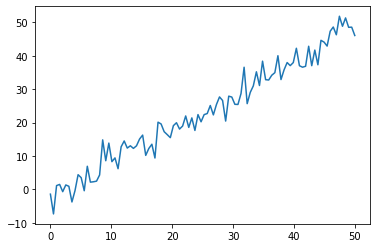

In [3]:
plt.plot(xdata, ydata);

Now we will write the PyMC3 model, keeping in mind that 1) data must be modifiable (both `x` and `y`) and 2) the model must be recompiled in order to be refitted with the modified data. We therefore have to create a function that recompiles the model when it's called. Luckily for us, compilation in PyMC3 is generally quite fast.

In [4]:
def compile_linreg_model(xdata, ydata):
    with pm.Model() as model:
        x = pm.Data("x", xdata)
        b0 = pm.Normal("b0", 0, 10)
        b1 = pm.Normal("b1", 0, 10)
        sigma_e = pm.HalfNormal("sigma_e", 10)

        y = pm.Normal("y", b0 + b1 * x, sigma_e, observed=ydata)
    return model

In [5]:
sample_kwargs = {"draws": 500, "tune": 500, "chains": 4}
with compile_linreg_model(xdata, ydata) as linreg_model:
    trace = pm.sample(**sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.917825834816141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850799498280131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818306765045102, but should be close to 0.8. Try to increase the number of tuning steps.


We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all refits use the same sampler parameters. 

We follow the same pattern with `az.from_pymc3`. 

Note however, how `coords` are not set. This is done to prevent errors due to coordinates and values shapes being incompatible during refits. Otherwise we'd have to handle subsetting of the coordinate values even though the refits are never used outside the refitting functions such as `reloo`.

We also exclude the `model` because the `model`, like the `trace`, is different for every refit. This may seem counterintuitive or even plain wrong, but we have to remember that the `pm.Model` object contains information like the observed data.

In [6]:
dims = {"y": ["time"], "x": ["time"]}
idata_kwargs = {
    "dims": dims,
    "log_likelihood": False,
}
idata = az.from_pymc3(trace, model=linreg_model, **idata_kwargs)

In [7]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

We are now missing the `log_likelihood` group due to setting `log_likelihood=False` in `idata_kwargs`. We are doing this to ease the job of the sampling wrapper. Instead of going out of our way to get PyMC3 to calculate the pointwise log likelihood values for each refit and for the excluded observation at every refit, we will compromise and manually write a function to calculate the pointwise log likelihood.

Even though it is not ideal to lose part of the straight out of the box capabilities of PyMC3, this should generally not be a problem. In fact, other PPLs such as Stan always require writing the pointwise log likelihood values manually (either within the Stan code or in Python). Moreover, computing the pointwise log likelihood in Python using xarray will be more efficient in computational terms than the automatic extraction from PyMC3. 

It could even be written to be compatible with Dask. Thus it will work even in cases where the large number of observations makes it impossible to store pointwise log likelihood values (with shape `n_samples * n_observations`) in memory.

In [8]:
def calculate_log_lik(x, y, b0, b1, sigma_e):
    mu = b0 + b1 * x
    return stats.norm(mu, sigma_e).logpdf(y)

This function should work for any shape of the input arrays as long as their shapes are compatible and can broadcast. There is no need to loop over each draw in order to calculate the pointwise log likelihood using scalars.

Therefore, we can use `xr.apply_ufunc` to handle the broadasting and preserve the dimension names:

In [9]:
log_lik = xr.apply_ufunc(
    calculate_log_lik,
    idata.constant_data["x"],
    idata.observed_data["y"],
    idata.posterior["b0"],
    idata.posterior["b1"],
    idata.posterior["sigma_e"],
)
idata.add_groups(log_likelihood=log_lik)

The first argument is the function, followed by as many positional arguments as needed by the function, 5 in our case. As this case does not have many different dimensions nor combinations of these, we do not need to use any extra kwargs passed to [`xr.apply_ufunc`](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html#xarray.apply_ufunc).

We are now passing the arguments to `calculate_log_lik` initially as `xr.DataArrays`. What is happening here behind the scenes is that `xr.apply_ufunc` is broadcasting and aligning the dimensions of all the DataArrays involved and afterwards passing numpy arrays to `calculate_log_lik`. Everything works automagically. 

Now let's see what happens if we were to pass the arrays directly to `calculate_log_lik` instead:

In [19]:
calculate_log_lik(
    idata.constant_data["x"].values,
    idata.observed_data["y"].values,
    idata.posterior["b0"].values,
    idata.posterior["b1"].values,
    idata.posterior["sigma_e"].values
)

ValueError: operands could not be broadcast together with shapes (4,500) (100,) 

If you are still curious about the magic of xarray and `xr.apply_ufunc`, you can also try to modify the `dims` used to generate the InferenceData a couple cells before:

    dims = {"y": ["time"], "x": ["time"]}
    
What happens to the result if you use a different name for the dimension of `x`?

In [10]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> log_likelihood

We will create a subclass of `az.SamplingWrapper`. 

In [11]:
class PyMC3LinRegWrapper(az.SamplingWrapper):        
    def sample(self, modified_observed_data):
        with self.model(*modified_observed_data) as linreg_model:
            idata = pm.sample(
                **self.sample_kwargs, 
                return_inferencedata=True, 
                idata_kwargs=self.idata_kwargs
            )
        return idata
    
    def get_inference_data(self, idata):
        return idata
        
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data["x"]
        ydata = self.idata_orig.observed_data["y"]
        mask = np.isin(np.arange(len(xdata)), idx)
        data__i = [ary[~mask] for ary in (xdata, ydata)]
        data_ex = [ary[mask] for ary in (xdata, ydata)]
        return data__i, data_ex

In [12]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.78     7.13
p_loo        2.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using Pareto Smoothed Importance Sampling (PSIS) works for all observations, so we will use modify `loo_orig` in order to make `az.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [13]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper. Let's stop ana analize each of the arguments. 

We'd generally use `model` to pass a model object of some kind, already compiled and reexecutable, however, as we saw before, we need to recompile the model every time we use it to pass the model generating function instead. Close enough.

We then use the `log_lik_fun` and `posterior_vars` argument to tell the wrapper how to call `xr.apply_ufunc`. `log_lik_fun` is the function to be called, which is then called with the following positional arguments:

    log_lik_fun(*data_ex, *[idata__i.posterior[var_name] for var_name in posterior_vars]
    
where `data_ex` is the second element returned by `sel_observations` and `idata__i` is the InferenceData object result of `get_inference_data` which contains the fit on the subsetted data. We have generated `data_ex` to be a tuple of DataArrays to it plays nicely with this call signature.

We use `idata_orig` as a starting point, and mostly as a source of observed and constant data which is then subsetted in `sel_observations`.

Finally, `sample_kwargs` and `idata_kwargs` are used to make sure all refits and corresponding InferenceData are generated with the same properties.

In [14]:
pymc3_wrapper = PyMC3LinRegWrapper(
    model=compile_linreg_model, 
    log_lik_fun=calculate_log_lik, 
    posterior_vars=("b0", "b1", "sigma_e"),
    idata_orig=idata,
    sample_kwargs=sample_kwargs, 
    idata_kwargs=idata_kwargs,
)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [15]:
loo_relooed = az.reloo(pymc3_wrapper, loo_orig=loo_orig)

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 13
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.9084390959319811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833232031335186, but should be close to 0.8. Try to increase the number of tuning steps.
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 42
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8788024509211416, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900598064671754, but should be close to 0.8. Try to increase the number of tuning steps.
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 56
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8949149672236311, but should be close to 0.8. Try to increase the number of tuning steps.
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 73
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8797995668769552, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882380854441132, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936869082173754, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
loo_relooed

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.77     7.13
p_loo        2.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [17]:
loo_orig

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.78     7.13
p_loo        2.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%